In [1]:
import mlflow
import mlflow.sklearn
import subprocess
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from typing import Dict, Any
import socket
import warnings

class RegressorTrainer:
    def __init__(self, experiment_name: str, regressor: BaseEstimator, param_space: Dict[str, Any], cv_splits: int = 5, n_iter: int = 50):
        """
        Initialize the RegressorTrainer.

        Parameters:
            experiment_name (str): The name of the MLflow experiment.
            regressor (sklearn model): The regressor to optimize.
            param_space (dict): The parameter space for Bayesian optimization.
            cv_splits (int): Number of splits for cross-validation (default is 5).
        """
        self.experiment_name = experiment_name
        self.regressor = regressor
        self.param_space = param_space
        self.cv_splits = cv_splits
        self.bayes_search: BayesSearchCV | None = None  # Will hold the BayesSearchCV object
        self.x_train: np.ndarray | None = None
        self.y_train: np.ndarray | None = None
        self.x_test: np.ndarray | None = None
        self.y_test: np.ndarray | None = None
        self.n_iter = n_iter
        warnings.simplefilter("ignore")
        
    def port_in_use(self, port):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            # This actually returns an int and not a bool
            return s.connect_ex(('localhost', port)) == 0

    def launch_mlflow_server(self):
        port = 5000
        if not self.port_in_use(port):
            try:
                subprocess.Popen(["py", "-m", "mlflow", "ui", "--port", str(port)], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                print(f"MLflow server launched at http://127.0.0.1:{port}")
            except Exception as e:
                print("Error launching MLflow server:", e)
        else:
            print(f"MLflow server is running at http://127.0.0.1:{port}")

    def set_data(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray) -> None:
        """
        Set the training and test data as class attributes.

        Parameters:
            x_train (np.ndarray): Training data features.
            y_train (np.ndarray): Training data labels.
            x_test (np.ndarray): Test data features.
            y_test (np.ndarray): Test data labels.
        """
        self.x_train = np.array(x_train)
        self.y_train = np.array(y_train)
        self.x_test = np.array(x_test)
        self.y_test = np.array(y_test)

    def setup_mlflow(self) -> None:
        """Set up MLflow configuration."""
        self.launch_mlflow_server()
        mlflow.set_experiment(self.experiment_name)
        mlflow.set_tracking_uri("http://localhost:5000/")
        mlflow.autolog()
        # if isinstance(self.regressor, XGBRegressor):
        #     print('xgboost')
        #     mlflow.xgboost.autolog()
        # else:
        #     mlflow.sklearn.autolog()
        mlflow.enable_system_metrics_logging()
        

    def perform_search(self) -> None:
        """Perform Bayesian optimization for hyperparameters."""
        if self.x_train is None or self.y_train is None:
            raise ValueError("Training data has not been set. Call `set_data` first.")
        
        # Set up TimeSeriesSplit for cross-validation
        tss = TimeSeriesSplit(n_splits=self.cv_splits)
        
        # Initialize and perform BayesSearchCV
        self.bayes_search = BayesSearchCV(
            estimator=self.regressor,
            search_spaces=self.param_space,
            n_iter=self.n_iter,  # Number of iterations for the search
            cv=tss,  # Cross-validation scheme
            scoring='neg_mean_squared_error',  # Metric for scoring
            n_jobs=-1,  # Use all available CPU cores
            verbose=1,  # To display progress
            random_state=4242  # Ensures reproducibility
        )
                
        self.bayes_search.fit(self.x_train, self.y_train)

    def evaluate_model(self) -> None:
        """Evaluate the best model on the test data and log metrics."""
        if self.x_test is None or self.y_test is None:
            raise ValueError("Test data has not been set. Call `set_data` first.")
        if self.bayes_search is None:
            raise ValueError("Bayesian search has not been performed. Call `perform_search` first.")

        best_regressor = self.bayes_search.best_estimator_

        # Evaluate the best model
        test_mse = mean_squared_error(self.y_test, best_regressor.predict(self.x_test))
        test_rmse = root_mean_squared_error(self.y_test, best_regressor.predict(self.x_test))

        # Log the best model and metrics to MLflow
        #mlflow.log_params(self.bayes_search.best_params_)
        #mlflow.log_metric("test mse", test_mse)
        #mlflow.log_metric("test rmse", test_rmse)

        # Log the model with an example
        #input_example = self.x_test[:5]
        #mlflow.sklearn.log_model(
        #    best_regressor,
        #    "best_model",
        #    input_example=input_example
        #)

        print("Best hyperparameters found by Bayesian optimization:", self.bayes_search.best_params_)
        print("Test MSE: ", test_mse)
        print("Test RMSE: ", test_rmse)
    
    # Autolog handles it automatically
    #def end_run(self) -> None:
    #    mlflow.end_run()

    def run(self) -> None:
        self.setup_mlflow()
        self.perform_search()
        self.evaluate_model()
        #self.end_run()


In [1]:
import pandas as pd
import numpy as np

x_train, y_train = pd.read_csv("../data/processed/x_train.csv", index_col=0), pd.read_csv("../data/processed/y_train.csv", index_col=0)
x_test, y_test = pd.read_csv("../data/processed/x_test.csv", index_col=0), pd.read_csv("../data/processed/y_test.csv", index_col=0)

In [12]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import yaml


with open('../configs/hyperparameter_search_spaces.yaml', 'r') as stream:
    param_space_config = yaml.safe_load(stream)

d_tree_param_space = param_space_config['decision_tree']


dtree_trainer = RegressorTrainer(
    experiment_name="DecisionTree-BayesianOptimization",
    regressor=DecisionTreeRegressor(),
    param_space=d_tree_param_space,
    n_iter=1
    
)

dtree_trainer.set_data(x_train, y_train, x_test, y_test)
dtree_trainer.run()

xgb_trainer = RegressorTrainer(
    experiment_name="XGBoost-BayesianOptimization",
    regressor=XGBRegressor(device='cuda'),
    param_space={'max_depth': (5, 30)},
    n_iter=1
)

#xgb_trainer.set_data(x_train, y_train, x_test, y_test)
#xgb_trainer.run()

rf_trainer = RegressorTrainer(
    experiment_name="RandomForest-BayesianOptimization",
    regressor=RandomForestRegressor(),
    param_space={'max_depth': (5, 30)},
    n_iter=1
)
#rf_trainer.set_data(x_train, y_train, x_test, y_test)
#rf_trainer.run()


2024/09/30 14:41:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


MLflow server is running at http://127.0.0.1:5000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/30 14:42:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:42:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: cannot access free variable '_create_dataset' where it is not associated with a value in enclosing scope
2024/09/30 14:42:15 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:42:25 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:42:26 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: cannot access free variable '_create_dataset' where it is not associated with a value in enclosing scope
2024/09/30 14:42:26 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: cannot access free varia

Best hyperparameters found by Bayesian optimization: OrderedDict([('max_depth', 34)])
Test MSE:  70.22671102661597
Test RMSE:  7.897698287929393


2024/09/30 14:42:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:42:46 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:42:57 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:43:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:43:17 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:43:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:43:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/30 14:43:48 WARNING

412
820
1228
1636
2044


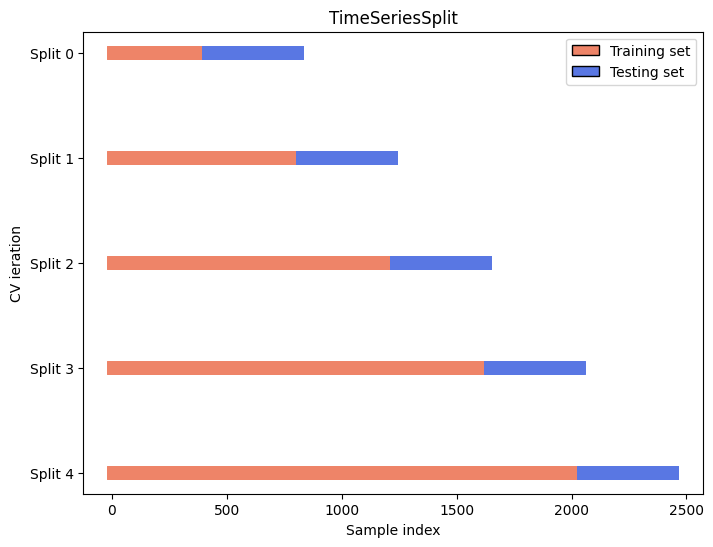

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit

# Create synthetic data
n_points = len(x_train)
n_splits = 5
X = np.random.randn(n_points, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(n_points * perc) for ii, perc in enumerate(percentiles_classes)])

def plot_cv_indices(cv, X, n_splits):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Generate color mapping for training/testing splits
    cmap_data = plt.cm.coolwarm
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        # Train set (blue)
        ax.scatter(train_index, [n_splits - i - 0.5] * len(train_index), c=[cmap_data(0.8)] * len(train_index), marker='_', lw=10, label='Training set' if i == 0 else "")
        # Test set (red)
        print(len(train_index))
        print(len(test_index))
        ax.scatter(test_index, [n_splits - i - 0.5] * len(test_index), c=[cmap_data(0.1)] * len(test_index), marker='_', lw=10, label='Testing set' if i == 0 else "")

    y_ticks = np.arange(n_splits) + 0.5
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'Split {n_splits - i - 1}' for i in range(n_splits)]) 
    ax.set_xlabel('Sample index')
    ax.set_ylabel('CV ieration')

    legend_elements = [Patch(facecolor=cmap_data(0.8), edgecolor='k', label='Training set'),
                       Patch(facecolor=cmap_data(0.1), edgecolor='k', label='Testing set')]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.title('TimeSeriesSplit')
    plt.show()

# Create the TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=n_splits)

# Plot the TimeSeriesSplit
plot_cv_indices(cv, X, n_splits)


In [3]:
print(x_train.shape)

(2452, 33)


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [15]:
# Importing necessary libraries
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import KFold, TimeSeriesSplit

# Set experiment and tracking URI
mlflow.set_experiment("DecisionTree-BayesianOptimization")
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.enable_system_metrics_logging()
mlflow.sklearn.autolog()

# Define the regressor
regressor = DecisionTreeRegressor()

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=False)

# Set up time series split
tss = TimeSeriesSplit(n_splits=5)

# Define the parameter space for Bayesian search


# Ensure x_train and x_test are NumPy arrays (or pandas DataFrames)
x_train = np.array(x_train)  # Convert your training data if it's a list
x_test = np.array(x_test)    # Ensure test data is also an array
y_train = np.array(y_train)
y_test = np.array(y_test)

# Start an MLflow run
with mlflow.start_run():
    # Set up BayesSearchCV for hyperparameter optimization
    bayes_search = BayesSearchCV(
        estimator=regressor,
        search_spaces=param_space,
        n_iter=50,  # Number of iterations for the search
        cv=tss,  # Cross-validation scheme
        scoring='neg_mean_squared_error',  # Metric for scoring
        n_jobs=-1,  # Use all available CPU cores
        verbose=1,  # To display progress
        random_state=4242  # Ensures reproducibility
    )
    
    # Perform Bayesian search
    bayes_search.fit(x_train, y_train)

    # Get the best estimator (regressor with the best hyperparameters)
    best_regressor = bayes_search.best_estimator_

    # Evaluate the best model
    test_mse = mean_squared_error(y_test, best_regressor.predict(x_test))
    test_rmse = root_mean_squared_error(y_test, best_regressor.predict(x_test))
    
    # Log the parameters and metrics to MLflow
    mlflow.log_params(bayes_search.best_params_)
    mlflow.log_metric("test mse", test_mse)
    mlflow.log_metric("test rmse", test_rmse)
    
    # Log the best model with an input example
    input_example = x_train[:5]  # Providing a small sample from training data as input example
    mlflow.sklearn.log_model(
        best_regressor, 
        "best_model",
        input_example=input_example
    )
    
    # Output results
    print("Best hyperparameters found by Bayesian optimization:", bayes_search.best_params_)
    print("Test MSE: ", test_mse)
    print("Test RMSE: ", test_rmse)


2024/09/29 15:09:59 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/09/29 15:10:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/09/29 15:10:00 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:10:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'


Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:10:01 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:01 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:01 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:10:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'


Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:10:08 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:08 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:08 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:10 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:10:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:10:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:10:27 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:27 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:27 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:10:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:10:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:10:47 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:47 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:47 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:10:51 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:10:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:10:52 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:11:07 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:07 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:08 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:11 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:11:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:11:13 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:11:27 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:27 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:27 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:11:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:11:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:11:47 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:47 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:47 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:11:51 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:11:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:11:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:12:07 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:07 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:07 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:12 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:12:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:12:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:12:34 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:34 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:34 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:12:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:12:40 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:12:55 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:55 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:12:55 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:13:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:13:02 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:13:15 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:15 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:16 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:13:22 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:13:23 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:13:37 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:37 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:37 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:13:42 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:13:42 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:13:54 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:54 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:54 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:13:55 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:13:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:13:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:14:14 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:14 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:14 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:16 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:14:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:14:20 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:14:34 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:34 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:35 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:14:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:14:42 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:14:58 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:58 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:14:58 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:15:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:15:06 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:15:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:15:20 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:20 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:21 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:15:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to a

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:15:45 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:45 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:45 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:15:47 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:15:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:15:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:16:04 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:04 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:04 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:07 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:16:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:16:11 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:16:26 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:26 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:26 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:28 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:16:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:16:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:16:47 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:47 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:48 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:16:48 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:16:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:16:54 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:17:10 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:10 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:10 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:17:16 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:17:17 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:17:29 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:17:29 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:29 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:29 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:17:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:17:50 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:50 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:50 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:17:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:17:56 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:17:57 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:18:11 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:18:11 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:18:11 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:18:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:18:20 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:18:20 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:18:38 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:18:38 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:18:38 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:18:40 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:18:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:18:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:19:02 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:02 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:03 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:19:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:19:10 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:19:25 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:25 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:25 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:31 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:19:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:19:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:19:49 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:49 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:49 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:19:51 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:19:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:19:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:20:12 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:12 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:12 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:20:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:20:20 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:20:35 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:35 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:35 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:20:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:20:42 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:20:56 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:56 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:20:56 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:21:02 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:21:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:21:17 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:17 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:17 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:22 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:21:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:21:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:21:44 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:44 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:44 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:21:50 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:21:51 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:22:17 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:22:18 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:22:18 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:22:18 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:22:23 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:22:34 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:22:36 WARNIN

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:22:57 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:22:57 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:22:57 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:23:04 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:23:05 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:23:21 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:21 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:22 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:25 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:23:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:23:29 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:23:44 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:44 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:44 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:23:45 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:23:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:23:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' obj

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:24:08 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:08 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:08 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:24:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:24:15 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Lo

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:24:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2024/09/29 15:24:32 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:32 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:32 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:36 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to a

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:24:56 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:24:57 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:57 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:24:57 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:25:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:25:06 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024/09/29 15:25:25 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GaussianProcessRegressor. Logging error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:25:25 WARNING mlflow.sklearn.utils: RegressorMixin.score failed. The 'training_score' metric will not be recorded. Scoring error: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:25:25 WARNING mlflow.sklearn: Failed to infer model signature: 'GaussianProcessRegressor' object has no attribute 'y_train_std_'
2024/09/29 15:25:27 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect GPU metrics.
2024/09/29 15:25:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/29 15:25:37 WARNING mlflow.system_metrics.metrics.gpu_monitor: Encountered error Not Supported when trying to collect

Best hyperparameters found by Bayesian optimization: OrderedDict([('ccp_alpha', 0.0), ('criterion', 'squared_error'), ('max_depth', 30), ('max_features', None), ('max_leaf_nodes', 23), ('min_impurity_decrease', 0.1723715899930956), ('min_samples_leaf', 30), ('min_samples_split', 24), ('min_weight_fraction_leaf', 0.0)])
Test MSE:  36.811349029728596
Test RMSE:  5.775873193483427


2024/09/29 15:26:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-cub-155 at: http://localhost:5000/#/experiments/803928810609079892/runs/78259ca813cf49b69fa3b94f35bd8e73.
2024/09/29 15:26:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/803928810609079892.
2024/09/29 15:26:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/09/29 15:26:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [20]:
import xgboost as xgb

xg_regressor = xgb.XGBRegressor()

# Set up time series split
tss = TimeSeriesSplit(n_splits=5)

param_space = {
    'max_depth': (3, 15),  # Limits the depth of each tree, typical values for structured data
    'learning_rate': (0.01, 0.3),  # Controls how much the model learns at each boosting step
    'n_estimators': (50, 500),  # Number of trees (boosting rounds)
    'subsample': (0.5, 1.0),  # Fraction of samples used per tree, prevents overfitting
    'colsample_bytree': (0.5, 1.0),  # Fraction of features used per tree, helps with feature selection
    'min_child_weight': (1, 10),  # Minimum sum of instance weight in a child, regularizes the model
    'gamma': (0, 10),  # Minimum loss reduction required for further partitioning, helps avoid overfitting
}

# Set up BayesSearchCV for hyperparameter optimization
bayes_search = BayesSearchCV(
    estimator=xg_regressor,
    search_spaces=param_space,
    n_iter=50,  # Number of iterations for the search
    cv=tss,  # Cross-validation scheme
    scoring='neg_mean_squared_error',  # Metric for scoring
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # To display progress
    random_state=42  # Ensures reproducibility
)

# Perform Bayesian search
bayes_search.fit(x_train, y_train)

# Get the best estimator (regressor with the best hyperparameters)
best_regressor = bayes_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred = best_regressor.predict(x_test)
val_mse = mean_squared_error(y_test, y_val_pred)

# Output results
print("Best hyperparameters found by Bayesian optimization:", bayes_search.best_params_)
print("Validation MSE:", val_mse)

In [ ]:
# Random forest

from sklearn.ensemble import RandomForestRegressor

fr_regressor = RandomForestRegressor()

tss = TimeSeriesSplit(n_splits=5)

param_space = {
    'n_estimators': (50, 500),            # Number of trees in the forest
    'max_depth': (3, 15),                 # Maximum depth of each tree
    'min_samples_split': (2, 10),         # Minimum number of samples required to split a node
    'min_samples_leaf': (1, 5),           # Minimum number of samples required at a leaf node
    'max_features': ('sqrt', 'log2', None), # Number of features to consider for the best split
    'bootstrap': (True, False),           # Whether to use bootstrap samples when building trees
    'min_weight_fraction_leaf': (0.0, 0.5), # Minimum weighted fraction of the sum total of weights for a leaf node
}

# Set up BayesSearchCV for hyperparameter optimization
bayes_search = BayesSearchCV(
    estimator=xg_regressor,
    search_spaces=param_space,
    n_iter=50,  
    cv=tss,  
    scoring='neg_mean_squared_error',  
    n_jobs=-1, 
    verbose=1, 
    random_state=42  
)

bayes_search.fit(x_train, y_train)

best_regressor = bayes_search.best_estimator_

y_val_pred = best_regressor.predict(x_test)
val_mse = mean_squared_error(y_test, y_val_pred)

print("Best hyperparameters found by Bayesian optimization:", bayes_search.best_params_)
print("Validation MSE:", val_mse)

In [39]:

import lightgbm as lgb

# Create an LGBMRegressor model
lgb_regressor = lgb.LGBMRegressor()

In [40]:
pd.DataFrame(y_val_pred)

y_val

In [63]:
np.sqrt(46.47046037002528)

In [ ]:
# show importance of features in xtrain based on xgboost feature selector
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot

xbg_reg = xgb.XGBRegressor().fit(x_train, y_train)

plot_importance(xbg_reg, importance_type='gain')
pyplot.show()